In [1]:
# pip install --upgrade tensorflow
%matplotlib inline
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')
# !pip install tensorflow
# !pip install keras_tuner

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras_tuner as kt

from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import metrics

lw = 1 # line weight for plt
SHUFFLE_BUFFER = 500
BATCH_SIZE = 32 # Model batch size
EPOCHS = 100 # Model number of epoch 
MODELS_RESULTS={} # store for all model result for both balanced and resampled datasets
n_classes=10
num_columns = 42  # Number of columns in df
regularizers=tf.keras.regularizers.l2(0.001)
print(tf.__version__)
plt.rcParams['figure.dpi'] = 500
plt.rcParams['savefig.dpi'] = 500

2.7.0


In [3]:
# importing the train and test data dataset from file
train_val_csv = pd.read_csv('./data/UNSW_NB15_training-set.csv')
test_csv = pd.read_csv('./data/UNSW_NB15_testing-set.csv')

In [4]:
train_val=train_val_csv.drop(columns=['id','label'])
test=test_csv.drop(columns=['id','label'])

In [5]:
# Split the data into train and test with 80 train / 20 test
train,val = train_test_split(train_val, test_size=0.2, random_state = 1)

In [6]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

65865 training examples
16467 validation examples
175341 test examples


In [7]:
CLASSES=['Normal','Generic', 'Exploits', 'Fuzzers', 'DoS', 'Backdoor', 'Reconnaissance', 'Analysis', 'Shellcode', 'Worms']
print(CLASSES)
# # five metrics used for evaluation process
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

['Normal', 'Generic', 'Exploits', 'Fuzzers', 'DoS', 'Backdoor', 'Reconnaissance', 'Analysis', 'Shellcode', 'Worms']


In [8]:
def plot_chart(history,name):
    plt.figure(figsize=(10, 10))
    names =['loss','accuracy']
    c=0
    for n in names:
        c=c+1
        n_val = 'val_'+n
        hist = history.history[n]
        hist_val = history.history[n_val]
        plt.subplot(len(names),1,c)
        plt.plot(hist, label='Training {}'.format(n))
        plt.plot(hist_val, label='Validation {}'.format(n))
        plt.legend(loc='lower right')
        plt.ylabel(n)
        plt.ylim(0.4,1)
        plt.title('{} Training and Validation {}'.format(name,n))
    plt.xlabel('epoch')
    return plt

In [9]:
def group_by_data_type(data):
    # data=data.drop(columns=DROP_COL)
    columns=data.columns # get list of columns
    unique=data.dtypes.unique() # select one of each dtype
    result={'number_col':[],'string_category_col':[],'int_category_col':[],'labels':[]}
    for col in columns:
        if col=='attack_cat': 
            temp= result['labels'] # init array
        elif data[col].dtypes=='float64': 
            temp= result['number_col'] # init array
        elif data[col].dtypes=='int64':
             temp= result['int_category_col'] # init array
        else:
            temp= result['string_category_col'] # init array
        temp.append(col) # append the array
    return result

In [10]:
# convert dataprame to tensore datasets
def dataframe_to_dataset_multi_feature(dataframe):
    attack_cat=dataframe.pop('attack_cat')
    x_num=tf.convert_to_tensor(dataframe[number_col])
    x_string=tf.convert_to_tensor(dataframe[string_category_col])
    x_int=tf.convert_to_tensor(dataframe[int_category_col])
    attack_cat = attack_cat.map(CLASSES.index)
    y=tf.keras.utils.to_categorical(attack_cat, num_classes=10)
    return [x_num,x_string,x_int],y

In [11]:
train_df = train.copy();
val_df = val.copy();
test_df = test.copy();

In [12]:
# seperate the structured data into individal type
data_types = group_by_data_type(train_df) # return result from
number_col=data_types['number_col']
string_category_col=data_types['string_category_col']
int_category_col=data_types['int_category_col']

In [13]:
print('numbers column', number_col)
print('_________________________________________________')
print('string column',string_category_col)
print('_________________________________________________')
print('integer column',int_category_col)

numbers column ['dur', 'rate', 'sload', 'dload', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'tcprtt', 'synack', 'ackdat']
_________________________________________________
string column ['proto', 'service', 'state']
_________________________________________________
integer column ['spkts', 'dpkts', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'swin', 'stcpb', 'dtcpb', 'dwin', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']


In [14]:
# ensure all preprosesing  layer adapt to the structure of the dataset 
dataframe = train_df.copy()
_ds= dataframe_to_dataset_multi_feature(dataframe)
X,y=_ds
input_num_shape = X[0].shape[1:]
input_string_shape = X[1].shape[1:]
input_int_shape = X[2].shape[1:]

adapt_input_num = X[0]
adapt_input_string = X[1]
adapt_input_int = X[2]
adapt_input_string

<tf.Tensor: shape=(65865, 3), dtype=string, numpy=
array([[b'udp', b'dns', b'INT'],
       [b'udp', b'dns', b'INT'],
       [b'tcp', b'-', b'FIN'],
       ...,
       [b'unas', b'-', b'INT'],
       [b'tcp', b'-', b'FIN'],
       [b'tcp', b'-', b'FIN']], dtype=object)>

In [15]:
# Create a Normalization layer and set its internal state using the training data
normalizer = layers.experimental.preprocessing.Normalization()
normalizer.adapt(adapt_input_num)

In [16]:
# Create a Intlookup layer and set its internal state using the training data
string_lookup = layers.StringLookup(output_mode="multi_hot")
string_lookup.adapt(adapt_input_string)
string_vocabulary=string_lookup.get_vocabulary()

In [17]:
# Create a Normalization layer and set its internal state using the training data
int_lookup = layers.IntegerLookup( output_mode="multi_hot")
int_lookup.adapt(adapt_input_int)

In [18]:
# # Load some data
def build_model(hp):
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Input layer for numeric data
    input_num = keras.Input(shape=input_num_shape, name='numeric_inputs')
    # include the normalization layer
    x1 = normalizer(input_num)
    # dence layers for numeric data
    hp_units_num_1 = hp.Int('units_num_1', min_value=32, max_value=512, step=32)
    x1 = layers.Dense(units=hp_units_num_1,activation='relu',kernel_regularizer=regularizers)(x1)
    x1 = layers.Dropout(0.5)(x1)
    
    hp_units_num_2 = hp.Int('units_num_2', min_value=32, max_value=512, step=32)
    x1 = layers.Dense(units=hp_units_num_2,activation='relu',kernel_regularizer=regularizers)(x1)
    x1 = layers.Dropout(0.5)(x1)
    
    hp_units_num_3 = hp.Int('units_num_3', min_value=32, max_value=512, step=32)
    x1 = layers.Dense(units=hp_units_num_3,activation='relu',kernel_regularizer=regularizers)(x1)
    x1 = layers.Dropout(0.5)(x1)
    
    output_num = layers.Dense(128,activation='relu',kernel_regularizer=regularizers)(x1)
    model_1=keras.models.Model(inputs=input_num, outputs=output_num)
    print('SUBMODAL-INTEGER-NUMERIC')
    model_1.summary()
    y1= model_1(input_num)
    
  # Input layer for integer cartegory data
    input_int = keras.Input(shape=input_int_shape, name='cartegory_integer_inputs')
  # include the int_lookup layer
    x2 = int_lookup(input_int)
  # dence layers for integer data
    hp_units_int_1 = hp.Int('units_int_1', min_value=32, max_value=512, step=32)
    x2 = layers.Dense(units=hp_units_int_1,activation='relu',kernel_regularizer=regularizers)(x2)
    x2 = layers.Dropout(0.5)(x2)
    
    hp_units_int_2 = hp.Int('units_int_2', min_value=32, max_value=512, step=32)
    x2 = layers.Dense(units=hp_units_int_2,activation='relu',kernel_regularizer=regularizers)(x2)
    x2 = layers.Dropout(0.5)(x2)
    
    hp_units_int_3 = hp.Int('units_int_3', min_value=32, max_value=512, step=32)
    x2 = layers.Dense(units=hp_units_int_3,activation='relu',kernel_regularizer=regularizers)(x2)
    x2 = layers.Dropout(0.5)(x2)

    output_int = layers.Dense(128,activation='relu',kernel_regularizer=regularizers)(x2)
    model_2=keras.models.Model(inputs=input_int, outputs=output_int)
    print('SUBMODAL-INTEGER-SUMMARY')
    model_2.summary()
    y2= model_2(input_int)
    
  # Input layer for string cartegory data
    input_string = keras.Input(shape=input_string_shape, name='cartegory_string_inputs',dtype='string')
  # include the int_lookup layer
    x3 = string_lookup(input_string)
  # dence layers for string data
    hp_units_string_1 = hp.Int('units_string_1', min_value=32, max_value=512, step=32)
    x3 = layers.Dense(units=hp_units_string_1,activation='relu',kernel_regularizer=regularizers)(x3)
    x3 = layers.Dropout(0.5)(x3)
    
    hp_units_string_2 = hp.Int('units_string_2', min_value=32, max_value=512, step=32)
    x3 = layers.Dense(units=hp_units_string_2,activation='relu',kernel_regularizer=regularizers)(x3)
    x3 = layers.Dropout(0.5)(x3)
    
    
    hp_units_string_3 = hp.Int('units_string_3', min_value=32, max_value=512, step=32)
    x3 = layers.Dense(units=hp_units_string_3,activation='relu',kernel_regularizer=regularizers)(x3)
    x3 = layers.Dropout(0.5)(x3)
    
    output_string = layers.Dense(128,activation='relu',kernel_regularizer=regularizers)(x3)
    model_3=keras.models.Model(inputs=input_string, outputs=output_string)
    print('SUBMODAL-STRING-SUMMARY')
    model_3.summary()
    y3= model_3(input_string)
    
    avg = tf.keras.layers.Average()([y1,y2,y3])
    output = layers.Dense(n_classes, activation="softmax")(avg)
    model = keras.Model(inputs=[input_num,input_string,input_int], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.CategoricalCrossentropy(), metrics=METRICS)
    return model

In [19]:
# model fix, compyling and visualisation 
# LATE-FUSION
df = train_df.copy()
X_train,y_train= dataframe_to_dataset_multi_feature(df)
df = val_df.copy()
X_val,y_val= dataframe_to_dataset_multi_feature(df)
df = test_df.copy()
X_test,y_test= dataframe_to_dataset_multi_feature(df)

In [20]:
print('LATE-FUSION')
name='LATE-FUSION'
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
print('fit model for:{}_____________________________________________________________________________________________________________'.format(name))
MODELS_RESULTS[name]={}
project_name='HYPERPARAM_'+name
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hyperparam_dir',
                     project_name=project_name)
print('----')
#     early stoppping if val_loss is behaving poorly
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#     hyperparameter search based on 50 epochs
tuner.search(X_train, y_train, epochs=50, validation_data=[X_val,y_val], callbacks=[stop_early])
    # Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
print('----')
history = model.fit(X_train,y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=[X_val,y_val])
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(X_train,y_train, batch_size=BATCH_SIZE, epochs=best_epoch, validation_data=[X_val,y_val])
print('evaluation result model for:{} on TRAIN_________________________________________________________'.format(name))
loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_train,y_train)
MODELS_RESULTS[name]['train']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
print('----')
print('----')
print('evaluation result model for:{} on VALIDATION________________________________________________________________________________'.format(name))
loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_val,y_val)
MODELS_RESULTS[name]['validation']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
print('----')
print('----')
print('evaluation result model for:{} on TEST________________________________________________________________________________'.format(name))
loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_test,y_test)
MODELS_RESULTS[name]['test']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
print('----')
print('----')
print('plot:{}_________________________________________________________'.format(name))

Trial 30 Complete [00h 26m 21s]
val_accuracy: 0.81927490234375

Best val_accuracy So Far: 0.8250440359115601
Total elapsed time: 20h 48m 41s
INFO:tensorflow:Oracle triggered exit
SUBMODAL-INTEGER-NUMERIC
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 numeric_inputs (InputLayer)  [(None, 11)]             0         
                                                                 
 normalization (Normalizatio  (None, 11)               23        
 n)                                                              
                                                                 
 dense_13 (Dense)            (None, 128)               1536      
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 352)             

2059/2059 [==============================] - 156s 76ms/step - loss: 0.6211 - accuracy: 0.8114 - precision: 0.9014 - recall: 0.7501 - auc: 0.9843 - prc: 0.9131 - val_loss: 0.5926 - val_accuracy: 0.8230 - val_precision: 0.9016 - val_recall: 0.7638 - val_auc: 0.9862 - val_prc: 0.9222
Epoch 11/100
2059/2059 [==============================] - 159s 77ms/step - loss: 0.6223 - accuracy: 0.8121 - precision: 0.9008 - recall: 0.7493 - auc: 0.9842 - prc: 0.9132 - val_loss: 0.5840 - val_accuracy: 0.8193 - val_precision: 0.8978 - val_recall: 0.7610 - val_auc: 0.9864 - val_prc: 0.9226
Epoch 12/100
2059/2059 [==============================] - 172s 84ms/step - loss: 0.6187 - accuracy: 0.8129 - precision: 0.8997 - recall: 0.7499 - auc: 0.9843 - prc: 0.9140 - val_loss: 0.5811 - val_accuracy: 0.8237 - val_precision: 0.9042 - val_recall: 0.7626 - val_auc: 0.9865 - val_prc: 0.9242
Epoch 13/100
2059/2059 [==============================] - 171s 83ms/step - loss: 0.6149 - accuracy: 0.8129 - precision: 0.8999 -

Epoch 38/100
2059/2059 [==============================] - 253s 123ms/step - loss: 0.5964 - accuracy: 0.8137 - precision: 0.9001 - recall: 0.7521 - auc: 0.9851 - prc: 0.9171 - val_loss: 0.5705 - val_accuracy: 0.8178 - val_precision: 0.9004 - val_recall: 0.7556 - val_auc: 0.9871 - val_prc: 0.9233
Epoch 39/100
2059/2059 [==============================] - 251s 122ms/step - loss: 0.5962 - accuracy: 0.8138 - precision: 0.9013 - recall: 0.7525 - auc: 0.9852 - prc: 0.9172 - val_loss: 0.5615 - val_accuracy: 0.8238 - val_precision: 0.9149 - val_recall: 0.7578 - val_auc: 0.9875 - val_prc: 0.9271
Epoch 40/100
2059/2059 [==============================] - 247s 120ms/step - loss: 0.5963 - accuracy: 0.8135 - precision: 0.9025 - recall: 0.7517 - auc: 0.9851 - prc: 0.9173 - val_loss: 0.5608 - val_accuracy: 0.8234 - val_precision: 0.9057 - val_recall: 0.7643 - val_auc: 0.9875 - val_prc: 0.9273
Epoch 41/100
2059/2059 [==============================] - 238s 116ms/step - loss: 0.5972 - accuracy: 0.8125 - pr

Epoch 66/100
2059/2059 [==============================] - 224s 109ms/step - loss: 0.5895 - accuracy: 0.8144 - precision: 0.9022 - recall: 0.7517 - auc: 0.9853 - prc: 0.9178 - val_loss: 0.5506 - val_accuracy: 0.8240 - val_precision: 0.9177 - val_recall: 0.7522 - val_auc: 0.9877 - val_prc: 0.9279
Epoch 67/100
2059/2059 [==============================] - 226s 110ms/step - loss: 0.5880 - accuracy: 0.8134 - precision: 0.9029 - recall: 0.7518 - auc: 0.9853 - prc: 0.9181 - val_loss: 0.5563 - val_accuracy: 0.8222 - val_precision: 0.9071 - val_recall: 0.7604 - val_auc: 0.9874 - val_prc: 0.9267
Epoch 68/100
2059/2059 [==============================] - 224s 109ms/step - loss: 0.5881 - accuracy: 0.8142 - precision: 0.9029 - recall: 0.7515 - auc: 0.9854 - prc: 0.9181 - val_loss: 0.5511 - val_accuracy: 0.8240 - val_precision: 0.9039 - val_recall: 0.7629 - val_auc: 0.9877 - val_prc: 0.9278
Epoch 69/100
2059/2059 [==============================] - 212s 103ms/step - loss: 0.5894 - accuracy: 0.8139 - pr

Epoch 94/100
2059/2059 [==============================] - 213s 103ms/step - loss: 0.5841 - accuracy: 0.8162 - precision: 0.9032 - recall: 0.7537 - auc: 0.9855 - prc: 0.9189 - val_loss: 0.5529 - val_accuracy: 0.8211 - val_precision: 0.9005 - val_recall: 0.7651 - val_auc: 0.9870 - val_prc: 0.9266
Epoch 95/100
2059/2059 [==============================] - 232s 113ms/step - loss: 0.5864 - accuracy: 0.8155 - precision: 0.9018 - recall: 0.7543 - auc: 0.9853 - prc: 0.9182 - val_loss: 0.5634 - val_accuracy: 0.8231 - val_precision: 0.9014 - val_recall: 0.7683 - val_auc: 0.9865 - val_prc: 0.9244
Epoch 96/100
2059/2059 [==============================] - 208s 101ms/step - loss: 0.5859 - accuracy: 0.8171 - precision: 0.9035 - recall: 0.7546 - auc: 0.9854 - prc: 0.9186 - val_loss: 0.5482 - val_accuracy: 0.8269 - val_precision: 0.9085 - val_recall: 0.7685 - val_auc: 0.9874 - val_prc: 0.9275
Epoch 97/100
2059/2059 [==============================] - 208s 101ms/step - loss: 0.5867 - accuracy: 0.8159 - pr

2059/2059 [==============================] - 219s 106ms/step - loss: 0.6441 - accuracy: 0.8102 - precision: 0.8990 - recall: 0.7436 - auc: 0.9832 - prc: 0.9090 - val_loss: 0.6367 - val_accuracy: 0.8111 - val_precision: 0.8903 - val_recall: 0.7538 - val_auc: 0.9839 - val_prc: 0.9117
Epoch 5/93
2059/2059 [==============================] - 222s 108ms/step - loss: 0.6382 - accuracy: 0.8108 - precision: 0.8997 - recall: 0.7446 - auc: 0.9836 - prc: 0.9104 - val_loss: 0.6105 - val_accuracy: 0.8170 - val_precision: 0.9010 - val_recall: 0.7479 - val_auc: 0.9853 - val_prc: 0.9182
Epoch 6/93
2059/2059 [==============================] - 213s 103ms/step - loss: 0.6325 - accuracy: 0.8120 - precision: 0.8986 - recall: 0.7478 - auc: 0.9836 - prc: 0.9108 - val_loss: 0.6051 - val_accuracy: 0.8180 - val_precision: 0.9041 - val_recall: 0.7480 - val_auc: 0.9860 - val_prc: 0.9189
Epoch 7/93
2059/2059 [==============================] - 242s 118ms/step - loss: 0.6266 - accuracy: 0.8129 - precision: 0.8977 - r

2059/2059 [==============================] - 168s 82ms/step - loss: 0.5964 - accuracy: 0.8143 - precision: 0.9000 - recall: 0.7514 - auc: 0.9848 - prc: 0.9157 - val_loss: 0.5721 - val_accuracy: 0.8198 - val_precision: 0.9019 - val_recall: 0.7573 - val_auc: 0.9869 - val_prc: 0.9237
Epoch 32/93
2059/2059 [==============================] - 166s 81ms/step - loss: 0.5969 - accuracy: 0.8140 - precision: 0.8987 - recall: 0.7507 - auc: 0.9849 - prc: 0.9157 - val_loss: 0.5752 - val_accuracy: 0.8206 - val_precision: 0.8973 - val_recall: 0.7606 - val_auc: 0.9865 - val_prc: 0.9233
Epoch 33/93
2059/2059 [==============================] - 160s 78ms/step - loss: 0.5950 - accuracy: 0.8130 - precision: 0.8994 - recall: 0.7515 - auc: 0.9849 - prc: 0.9159 - val_loss: 0.5762 - val_accuracy: 0.8176 - val_precision: 0.8945 - val_recall: 0.7587 - val_auc: 0.9862 - val_prc: 0.9223
Epoch 34/93
2059/2059 [==============================] - 165s 80ms/step - loss: 0.5972 - accuracy: 0.8142 - precision: 0.8992 - re

2059/2059 [==============================] - 162s 79ms/step - loss: 0.5869 - accuracy: 0.8164 - precision: 0.9021 - recall: 0.7546 - auc: 0.9851 - prc: 0.9178 - val_loss: 0.5818 - val_accuracy: 0.8163 - val_precision: 0.8922 - val_recall: 0.7647 - val_auc: 0.9857 - val_prc: 0.9198
Epoch 59/93
2059/2059 [==============================] - 165s 80ms/step - loss: 0.5878 - accuracy: 0.8153 - precision: 0.9002 - recall: 0.7542 - auc: 0.9851 - prc: 0.9174 - val_loss: 0.5569 - val_accuracy: 0.8236 - val_precision: 0.9031 - val_recall: 0.7660 - val_auc: 0.9873 - val_prc: 0.9265
Epoch 60/93
2059/2059 [==============================] - 159s 77ms/step - loss: 0.5863 - accuracy: 0.8165 - precision: 0.9019 - recall: 0.7543 - auc: 0.9852 - prc: 0.9179 - val_loss: 0.5645 - val_accuracy: 0.8200 - val_precision: 0.9018 - val_recall: 0.7561 - val_auc: 0.9867 - val_prc: 0.9248
Epoch 61/93
2059/2059 [==============================] - 160s 78ms/step - loss: 0.5857 - accuracy: 0.8138 - precision: 0.9004 - re

Epoch 86/93
2059/2059 [==============================] - 158s 77ms/step - loss: 0.5807 - accuracy: 0.8147 - precision: 0.9004 - recall: 0.7554 - auc: 0.9853 - prc: 0.9185 - val_loss: 0.5597 - val_accuracy: 0.8222 - val_precision: 0.8999 - val_recall: 0.7672 - val_auc: 0.9866 - val_prc: 0.9251
Epoch 87/93
2059/2059 [==============================] - 157s 76ms/step - loss: 0.5809 - accuracy: 0.8156 - precision: 0.9007 - recall: 0.7551 - auc: 0.9853 - prc: 0.9183 - val_loss: 0.5634 - val_accuracy: 0.8223 - val_precision: 0.9118 - val_recall: 0.7531 - val_auc: 0.9877 - val_prc: 0.9267
Epoch 88/93
2059/2059 [==============================] - 157s 76ms/step - loss: 0.5831 - accuracy: 0.8138 - precision: 0.9015 - recall: 0.7548 - auc: 0.9852 - prc: 0.9179 - val_loss: 0.5549 - val_accuracy: 0.8247 - val_precision: 0.8974 - val_recall: 0.7726 - val_auc: 0.9872 - val_prc: 0.9272
Epoch 89/93
2059/2059 [==============================] - 158s 77ms/step - loss: 0.5832 - accuracy: 0.8136 - precision:

<module 'matplotlib.pyplot' from '/Users/abiodunayantayo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

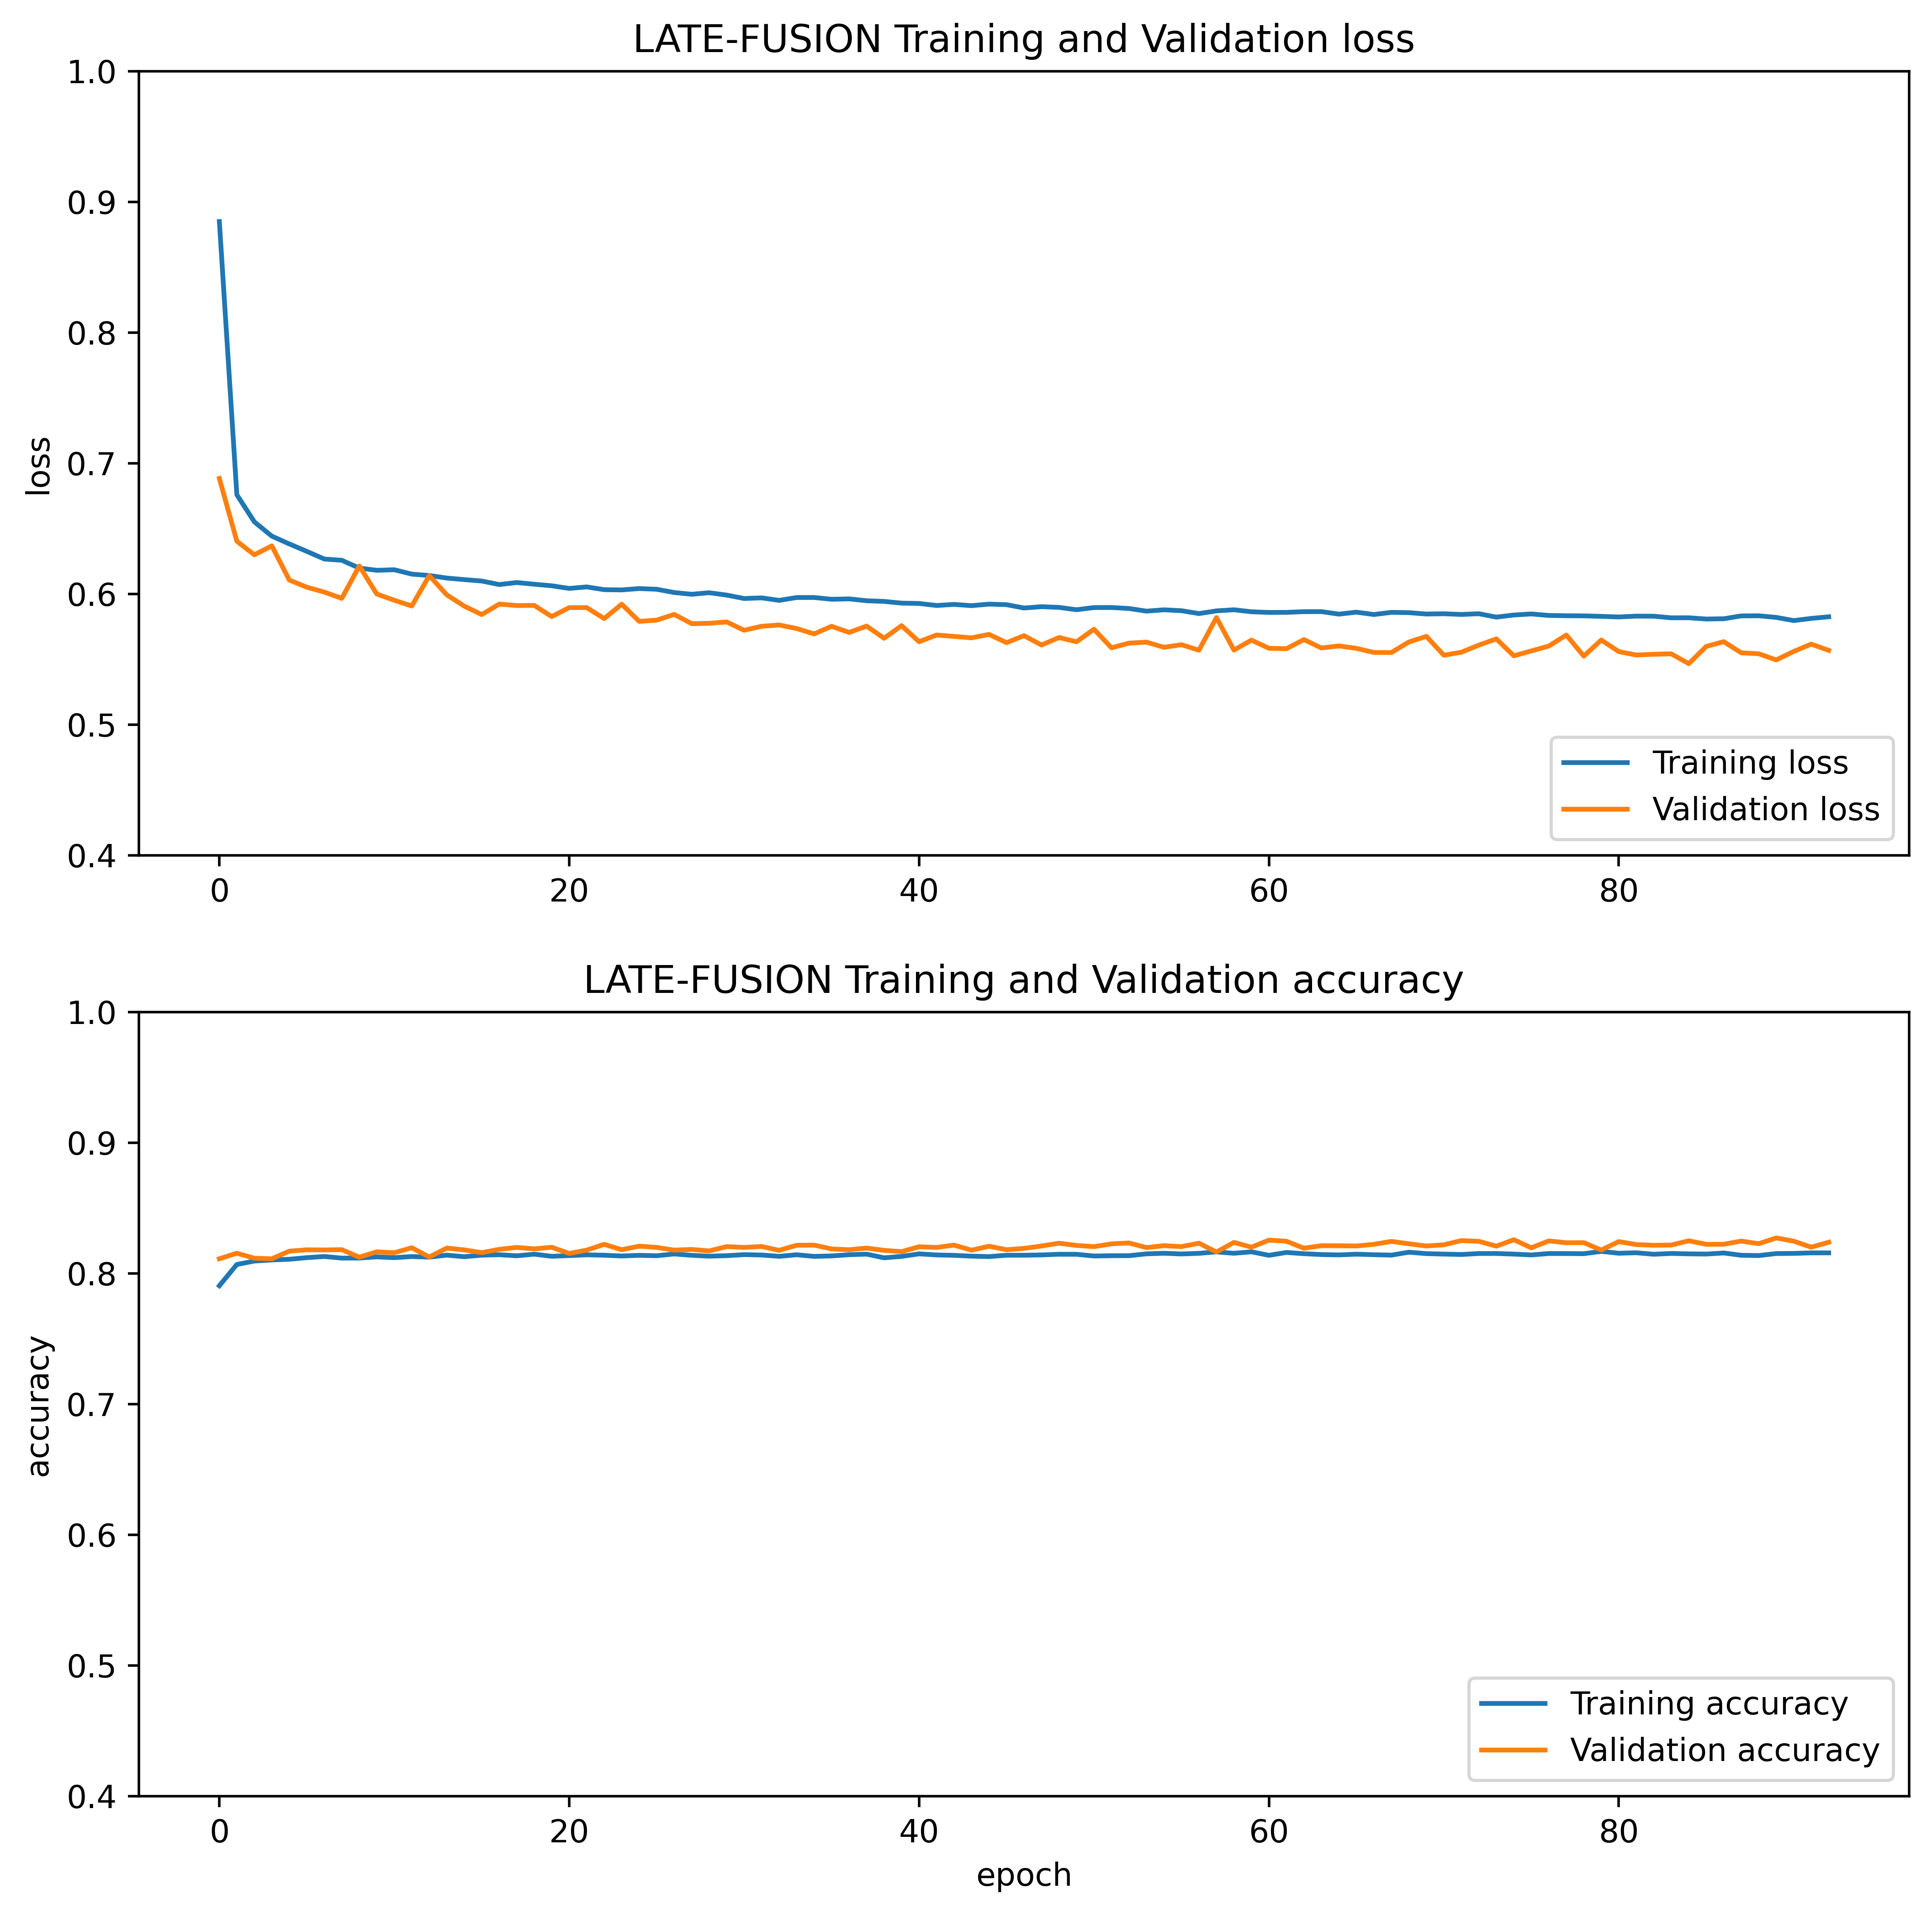

In [21]:
plot_chart(history,name)

In [22]:
y_pred = hypermodel.predict(X_test)

In [23]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

In [24]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)


for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes

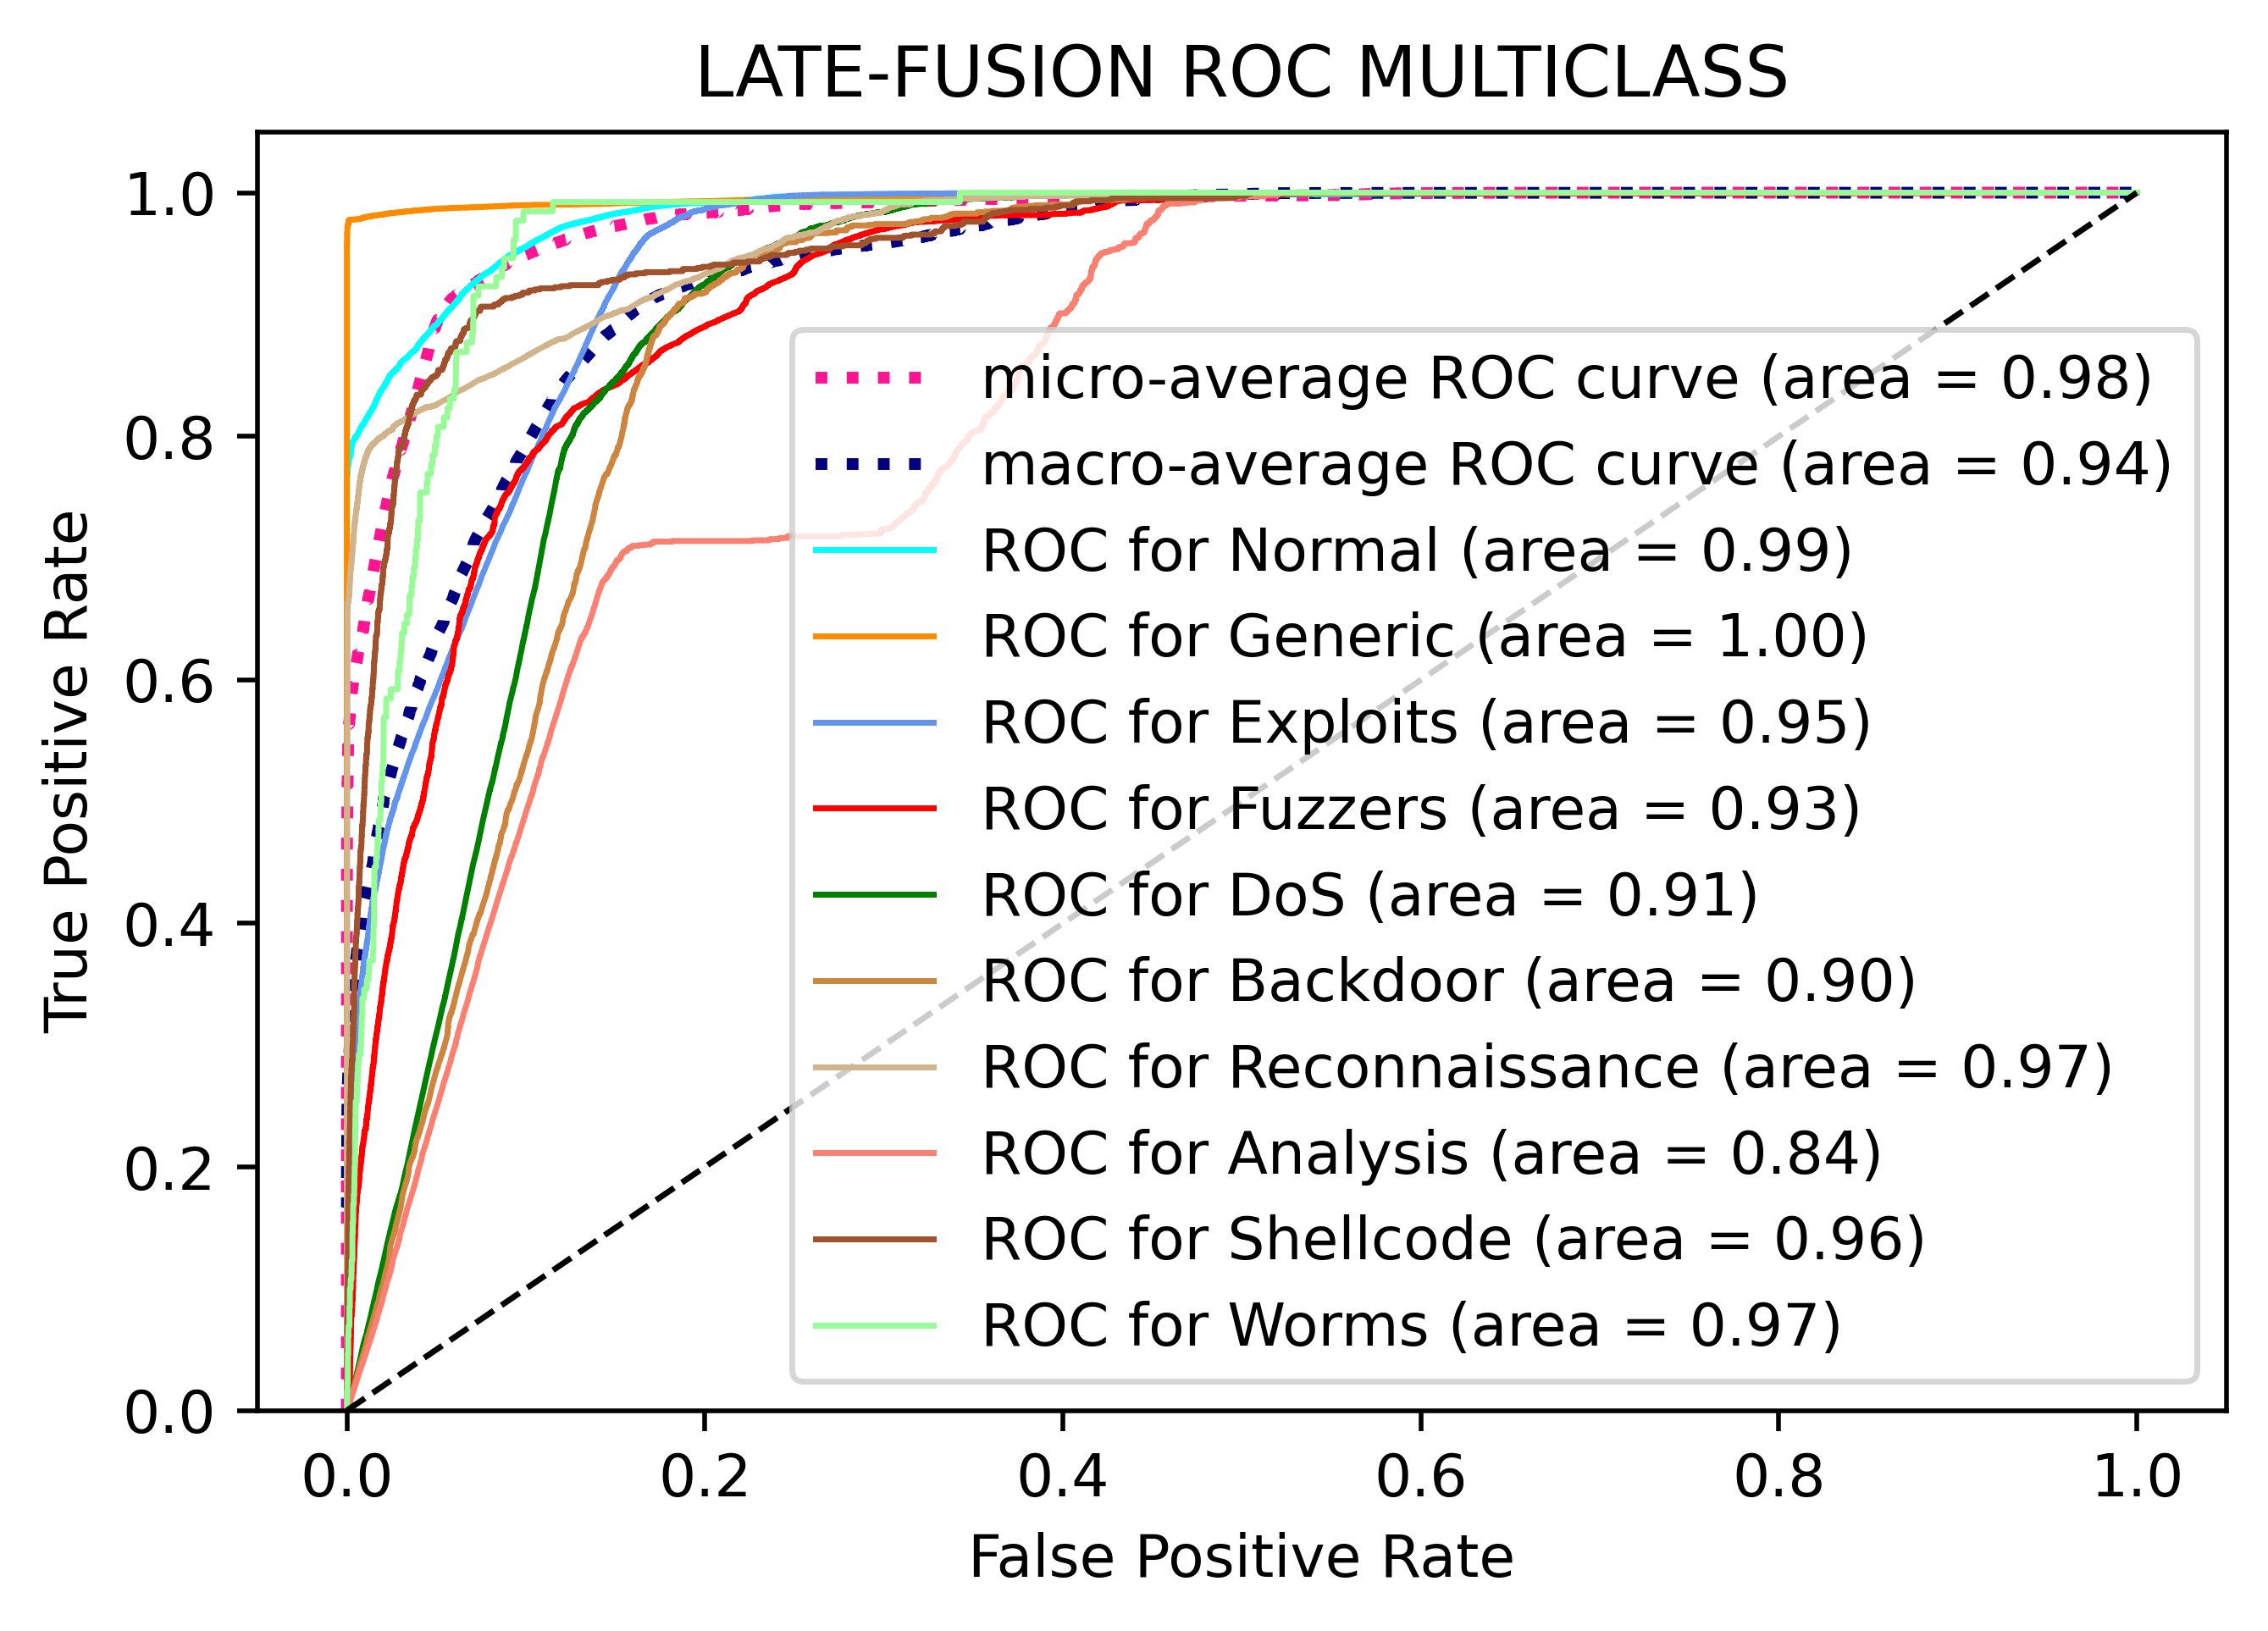

In [25]:
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=2,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=2,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue","red","green","peru","tan","salmon","sienna","palegreen"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=1,
        label="ROC for {0} (area = {1:0.2f})".format(CLASSES[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
# plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LATE-FUSION ROC MULTICLASS")
plt.legend(loc="lower right")
plt.show()

In [26]:
MODELS_RESULTS

{'LATE-FUSION': {'train': {'loss': 0.5330257415771484,
   'accuracy': 0.8278599977493286,
   'precision': 0.9076367020606995,
   'recall': 0.7735823392868042,
   'auc': 0.9882879257202148,
   'prc': 0.9307060241699219},
  'validation': {'loss': 0.556734561920166,
   'accuracy': 0.8237687349319458,
   'precision': 0.9008146524429321,
   'recall': 0.765531063079834,
   'auc': 0.9874221086502075,
   'prc': 0.9264591932296753},
  'test': {'loss': 0.6911858916282654,
   'accuracy': 0.764156699180603,
   'precision': 0.8546651601791382,
   'recall': 0.6781471371650696,
   'auc': 0.9777418375015259,
   'prc': 0.8834820985794067}}}

In [27]:
pd.DataFrame(MODELS_RESULTS['LATE-FUSION'])

,train,validation,test
loss,0.533026,0.556735,0.691186
accuracy,0.827860,0.823769,0.764157
precision,0.907637,0.900815,0.854665
recall,0.773582,0.765531,0.678147
auc,0.988288,0.987422,0.977742
prc,0.930706,0.926459,0.883482
